#### Linear Models and Regularization Methods
 
##### We can extend the linear model framework by generalizing the equation to accomodate non-linear, but still additive relationships.
##### Linear model has distinct advantages in terms of inference and, on real-world problems and is surprisingly competitive in relation to non-linear methods. Therefore this chapter discusses some of the ways in which the simple linear model can be improved, by replacing plain least squares fitting with some altertnative fitting procedures.
##### Alternative fitting procedures can yield better ***prediction accuracy*** and ***model interpretability***.
##### Here we look at various approaches for automatically perfoming ***feature selection/variable selection***--that is excluding irrelevant variables from a multiple regression model.***(model intepretability).***
##### if ***p > n***, there is no longer a unique coefficient estimate as compared to when ***n >> p*** where the least squares estimates tend to have low variance and hence performs well on test observations. if ***n*** is not much larger than ***p***, then there can be a lot of variability in the least squares fit, resulting in overfitting and consequently poor predictions on future observations not used in model training.
##### Therefore in this chapter we look at approaches that improve the accuracy by ***constraining/shrinking*** the estimated coefficients,reducing the variance at the cost of a negligible increase in bias.***(Prediction accuracy)***

##### There are many alternatives, both classical and modern, to using least squares fit. Here we look at 3 important classes of methods.
##### ***Subset Selection***: This approach involves identifying a subset of the ***p*** predictors that we believe to be related to the response. We then fit a model using least squares on the reduced set of variables.
##### ***Shrinkage***:This approach involves fitting a model involving all ***p*** predictors. However, the estimated coefficients are shrunken towards zero relative to the least squares estimates.This shrinkage ***(regularization)*** has the effect of reducing variance.
##### ***Dimension Reduction***: This approach involves projecting the ***p*** predictors into an M-dimensional subspace, where ***M < p***. This is achieved by computing ***M** different linear combinations, or projections of the variables. Then these ***M*** projections are used as predictors to fit a linear regression model by least squares.


In [1]:
!pip install numpy pandas matplotlib statsmodels

In [2]:
!pip install ISLP

In [3]:
 !pip install l0bnb

In [4]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
#from sklearn.feature_selection import SelectKBest, f_regression, RFE
#from sklearn.linear_model import lasso_path (visualizes coefficient paths as regularization changes)
from l0bnb import fit_path


#### Subset Selection Methods.
##### Here we implement the methods that reduce the number of parameters in a model by restricting the model to a subset of the input variables.
##### We will apply the ***forward-selection*** approach to the ***Hitters*** data. We wish to predict a baseball player's ***Salary*** on the basiy of various statistics associated with performance in the previous year.

In [5]:
Hitters = load_data("Hitters")
np.isnan(Hitters["Salary"]).sum()

59

In [6]:
#drop all the rows that have missing values
Hitters= Hitters.dropna()
Hitters.shape

(263, 20)

In [7]:
#We first choose the best model using forward selection based on Cp 
#This score is not built in as a metric to sklearn. We therefore define a function to compute it ourselves, and use it as a scorer. 
#By default, sklearn tries to maximize a score, hence our scoring function computes the negative Cp statistic.

def nCp(sigma2, estimator, X, Y):
    #Negative Cp statistic
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2)/n

In [8]:
#we need to estimate the residual variance, which is the first argument in our scoring function above
#We will fit the biggest model, using all the variables and estimate variance based on its MSE
design= MS(Hitters.columns.drop("Salary")).fit(Hitters)
Y= np.array(Hitters["Salary"])
X = design.transform(Hitters)
sigma2= OLS(Y,X).fit().scale
sigma2
#design.terms

99591.35617968219

In [9]:
# The function sklearn_selected() expects a scorer with just three arguments-- the last three in the definition of nCp() above
#We use the partial() function to freeze the first argument with our estimate of variance
neg_Cp= partial(nCp, sigma2) #can now be used as a scorer for model selection

In [10]:
#Along with a score we need to specify the search strategy. This is done through the object Stepwise().
#The method Stepwise.first_peak() runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score
strategy = Stepwise.first_peak(design, direction= "forward", max_terms=len(design.terms))

In [11]:
#We now fit a linear regression model with Salary as outcome using forward selection. we use the function sklearn_selected()
#This takes a model from statsmodels along with a search strategy and selects a model with its fit method. Without specifying a scoring argument, the score defaults to MSE and so all 19 variables will be selected
hittersMSE = sklearn_selected(OLS, strategy)
hittersMSE.fit(Hitters, Y)
hittersMSE.selected_state_


('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [12]:
# using neg_Cp results in a smaller model as expected with just 10 variables selected
hittersCp= sklearn_selected(OLS, strategy, scoring=neg_Cp)
hittersCp.fit(Hitters, Y)
hittersCp.selected_state_
                            #Alternatively
#from sklearn.feature_selection import SequentialFeatureSelector
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import make_scorer

#def neg_Cp(estimator, X, Y):
    #n,p = X.shape
    #yhat= estimator.predict(X)
   # RSS= np.sum((Y-yhat)**2)
  #  sigma2= RSS / (n-p)
 #   return-(RSS + 2 * p * sigma2)/n
#neg_Cp_scorer = make_scorer(neg_Cp, greater_is_better=True)    
#base model
#ols= LinearRegression()
#forward selection (choose k features)
#sfs= SequentialFeatureSelector(ols,
    #                           n_features_to_select= 10,
   #                            direction="forward",
  #                             scoring=neg_Cp_scorer,
 #                              cv=5) #cross-validation
#sfs.fit(Hitters, Y)
#print("Selected features:", Hitters.columns[sfs.get_support()])


('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing Among Models Using the Validation Set Approach and Cross-Validation

##### Alternative to using Cp, we might try cross-validation to select a model in forward direction. For this we need a method that stores the full path of models found in forward selection and allows predictions for each of these
##### The function cross_val_predict() from ISLP.models computes the cross-validated predictions for each of the models along the path, which we can use to evaluate the cross-validated MSE along the path.

In [13]:
strategy= Stepwise.fixed_steps(design, len(design.terms), direction="forward")
full_path= sklearn_selection_path(OLS, strategy)

#we now fit the full forward-selection path on the Hitters data and compare the fitted values
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

(50000.0, 250000.0)

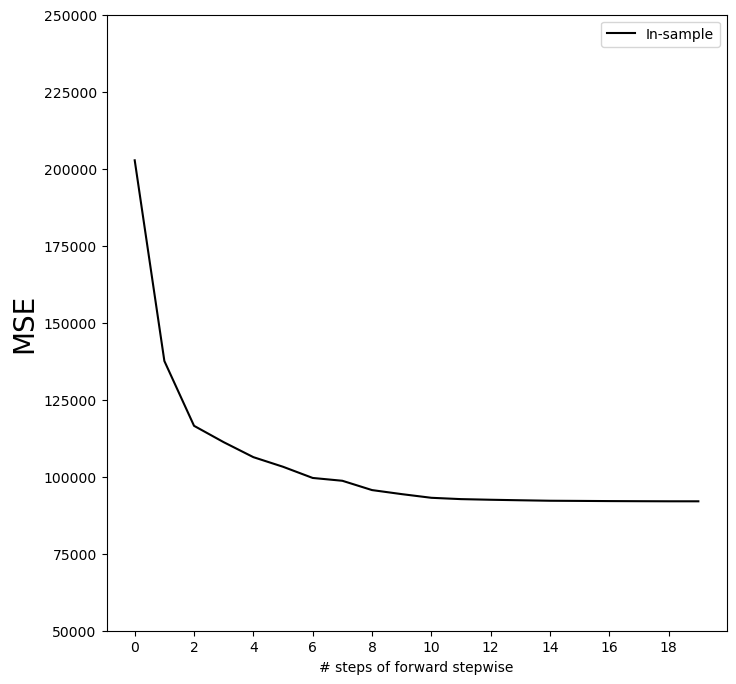

In [14]:
#The above gives an array of fitted values- 20 steps in all, including the fitted mean for the null model which we can use to evaluate in-sample MSE.
#The in-sample MSE improves each step we take, indicating we must use either the validation or cross-validation approach to select the number of steps.
#We fix the y-axis to range from 50,000 - 250,000 to compare to the cross-validation and validation set MSE as well as other methods such as ridge regression, lasso and principal components regression

mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
       insample_mse,
       "k", #color black
        label = "In-sample")
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("# steps of forward stepwise")
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000])

#The expresssion None in Y[:,None] adds ana axis(dimension) to the one-dimensional array Y, which allows it to be recycled when subtracted from the 2-D Yhat_in


In [15]:
#We are now ready to use the cross-validation to estimate the test error along the model path. We must use only the training observations to perform all aspects of model-fitting including variable selection.
#we compute the cross-validated predicted values using 5-fold cross validation
K = 5
kfold= skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)
Yhat_cv.shape

#The prediction matrix Yhat_cv is the same shape as Yhat_in: the difference is that the predictions in each row, corresponding to a particular sample index, were made from models fit on a training fold that did not include that row
#At each model along the path, we compute the MSE in each of the cross-validation folds. These we will average to get the mean MSE and can also use the individual values to compute a crude estimate of the SE of the mean.
#Therefore we must know the test indices for each cross-validation split

(263, 20)

In [16]:
#At each model along the path, we compute the MSE in each of the cross-validation folds. These we will average to get the mean MSE and can also use the individual values to compute a crude estimate of the SE of the mean.
#Therefore we must know the test indices for each cross-validation split
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors= (Yhat_cv[test_idx] - Y[test_idx, None])**2
    cv_mse.append(errors.mean(0)) #column means
cv_mse= np.array(cv_mse).T
cv_mse.shape

(20, 5)

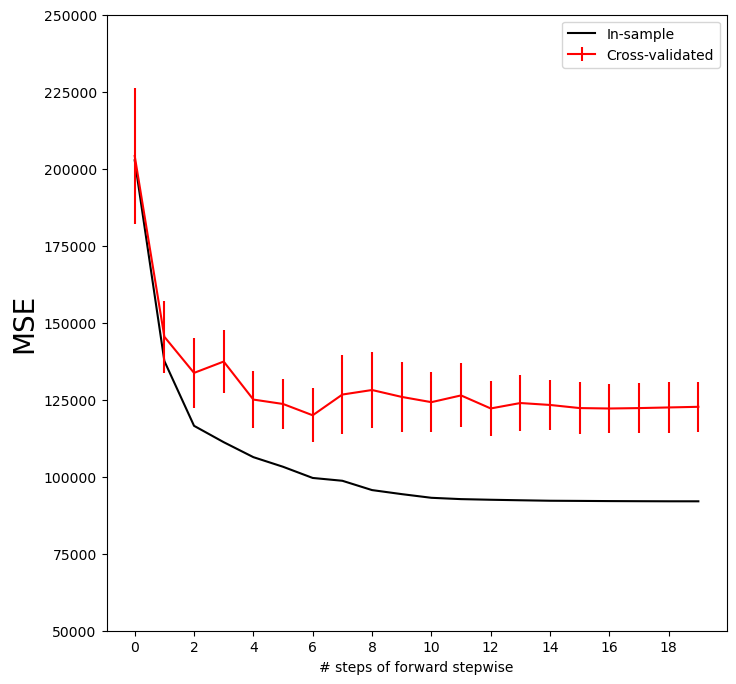

In [17]:
#We now add the cross-validation error estimates to our MSE plot. We include the mean error across the five folds, and the estimate of the standard error of the mean
ax.errorbar(np.arange(n_steps),
           cv_mse.mean(1),
           cv_mse.std(1) / np.sqrt(K),
           label="Cross-validated",
           c= "r")
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

In [18]:
#To repeat the above using the validation set approach, we simply change our cv argument to a validation set: one random split of the data into a test and training.
#We choose a test size of 20%, similary to the size of each test set in 5-fold cross-validation
validation= skm.ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val= full_path.predict(Hitters.iloc[test_idx])
    errors=(Yhat_val - Y[test_idx, None])**2
    validation_mse= errors.mean(0)

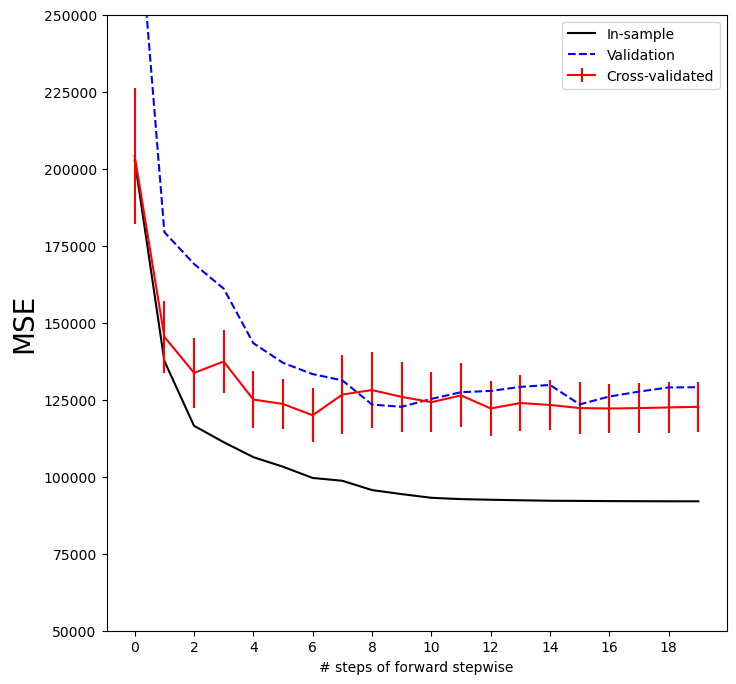

In [19]:
#As for the in-sample MSE case, the validation set approach does not provide standard errors
ax.plot(np.arange(n_steps),
       validation_mse,
       "b--", # color blue, broken line
        label="Validation")
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

#### Best Subset Selection

##### Forward stepwise is a greedy selection procedure: at each step it augments the current set by including one additional variable.
##### We now apply the best subset selection to the ***Hitters*** data, which for every subset size, searches for the best of predictors.
##### We will use a package called ***l0bnb*** to perform best subset selection. Instead of constraining the subset to be a given size, this package produces a path of solutions using the subset size as a penalty rather than a constraint. Although the distinction is subtle, the difference comes when we cross-validate.

In [20]:
#we exclude the first column corresponding to the intercept, as l0bnb will fit the intercept separately.
#We can find a path using the fit_path() function
D= design.fit_transform(Hitters)
D= D.drop("intercept", axis=1)
X=np.asarray(D)
path= fit_path(X, Y, max_nonzeros= X.shape[1])
path[3]

#The function fit_path() returns a list whose values include the fitted coefficients as B, an intercept as B0, as well as a few attributes related to the particular path algo used.
#In the example above, we see that at the fourth step in the path, we have two nonzero coefficients in B, corresponding to the value 0.114 for the penalty parameter lambda_0.
#We could make predictions using this sequence of fits on a validation set as a function of lambda_0, or with more work using cross-validation

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.01141624802745019,
 'M': 0.5829861733382014,
 'Time_exceeded': False}

#### Ridge Regression and the Lasso

##### We will use the ***sklearn.linear_model*** package to fit the ridge and lasso regularized linear models on the ***Hitters*** data. We start with the model matrix ***X***(without intercept) that we computed in the previous cell on best subset regression.

#### Ridge Regression

##### We will use the function ***skl.ElasticNet()*** to fit both the ridge and the lasso. To fit a path of ridge regressions models, we use ***skl.ElasticNet.Path()***, which can fit both ridge and lasso, as well as a hybrid mixture; ridge regression corresponds to ***l1_ratio=0***.
##### It is good practice to standardize the columns of ***X*** in these applications, if the variables are measured in different units.
##### Since ***skl.ElasticNet()*** does no normalization, we have to take care of that ourselves. Since we standardize first, in order to find coefficient estimates on the original scale, we must unstandardize the coefficient estimates.
##### The parameter  parameter ***λ***(tuning parameter) is called ***alphas*** in ***sklearn***. Here we use ***lambdas*** rather than ***alphas***. 

In [21]:
#Centering each column of X by subtracting its mean. This ensures predictors have a mean=0
Xs = X - X.mean(0)[None,:]
#Standardizing predictors by dividing each column by its SD. Now each predictor has mean=0 and variance=1
X_scale = X.std(0)
Xs= Xs / X_scale[None,:]
#This creates 100 values of regularization strength(λ), ranging from 10^8 down to 10^-2 logarithmically spaced.
#Dividing by Y.std() rescales so that λ is on a comparable scale to the data.
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0, alphas=lambdas)[1] #a tuple is returned (alphas, coefs, gaps)
soln_array.shape

C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Obj

(19, 100)

In [22]:
#We transpose the matrix 19 x 100 and turn it into a dataframe to facilitate viewing and plotting
soln_path = pd.DataFrame(soln_array.T,
                        columns=D.columns,
                        index= -np.log(lambdas))
soln_path.index.name= "negative log(lambda)"
soln_path
                

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


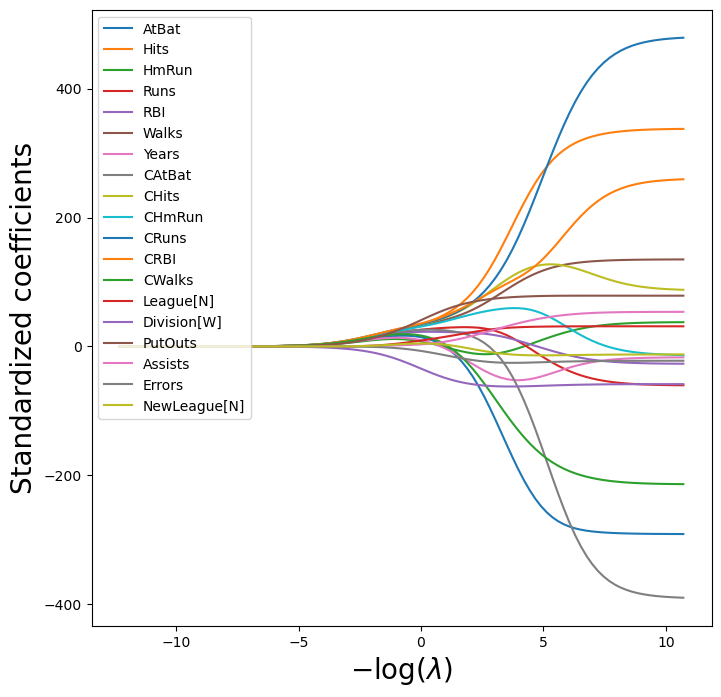

In [23]:
#We plot the paths to get a sense of how the coefficients vary with λ.
#To control the location of the legend, we first set legend to False in the plot method, adding it afterward with the legend() method of ax
path_fig, ax= subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Standardized coefficients", fontsize=20)
ax.legend(loc="upper left")


In [24]:
#we expect the coefficient estimates to be much smaller, in terms of l2 norm when a large value of λ is used, as compared to when a small value of λ is used.
#Recall that the l2 norm is the square root of the sum of squared coefficient values.
#we display the coefficients at the 40th step, where λ is 25.535
beta_hat= soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [25]:
#lets compute the l2 norm of the standardized coefficients
np.linalg.norm(beta_hat) #the Euclidian length of the coefficient vector at the 39th lambda

24.17061720144378

In [26]:
# In contrast, here is the l2 norm when the lambda is 2.44e-01. Note the much larger l2 norm of the coefficients associated with this smaller value of lambda
beta_hat= soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017725955)

##### Above we normalized ***X*** upfront, and fit the ridge model on ***Xs***. The ***Pipeline()*** object in ***sklearn*** provides a clear way to separate feature normalization from the fitting of the ridge model itself

In [27]:
ridge= skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler= StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[("scaler", scaler), ("ridge", ridge)])
pipe.fit(X, Y)
np.linalg.norm(ridge.coef_)

C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


160.42371017725927

#### Estimating Test Error of Ridge Regression

##### Choosing a priori value of lambda for ridge regression is difficult. We want to use the validation method or cross-validation to select the tuning parameter.

In [28]:
validation = skm.ShuffleSplit(n_splits=1, test_size= 0.5, random_state=0)
ridge.alpha=0.01
results= skm.cross_validate(ridge, X, Y, scoring= "neg_mean_squared_error", cv=validation)
-results["test_score"]

#Note that if we had instead simply fit a model with just an intercept, we would have predicted each test observation using the mean of the training observations.

C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134214.00419204])

In [29]:
#We can get same result by fitting a ridge regression model with a very large value of lambda. note that 1e10 means 10 ^ 10
ridge.alpha=1e10
results= skm.cross_validate(ridge, X, Y, scoring="neg_mean_squared_error", cv=validation)
-results["test_score"]


C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([231788.32155285])

##### Obviously choosing λ=0.01 is arbitrary, so we will use cross-validation or the validation set approach to choose the tuning parameter λ.
##### The object ***GridSearchCV()*** allows exhaustive grid search to choose such a parameter.

In [30]:
param_grid = {"ridge__alpha":lambdas}
grid= skm.GridSearchCV(pipe,
                      param_grid,
                      cv=validation,
                      scoring="neg_mean_squared_error")
grid.fit(X, Y)
grid.best_params_["ridge__alpha"]
#grid.best_estimator_

C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

0.005899006046740856

In [31]:
#alternatively we can use 5-fold CV
grid= skm.GridSearchCV(pipe,
                      param_grid,
                      cv=kfold,
                      scoring="neg_mean_squared_error")
grid.fit(X,Y)
grid.best_params_["ridge__alpha"]
grid.best_estimator_

C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

Text(0, 0.5, 'Cross-validated MSE')

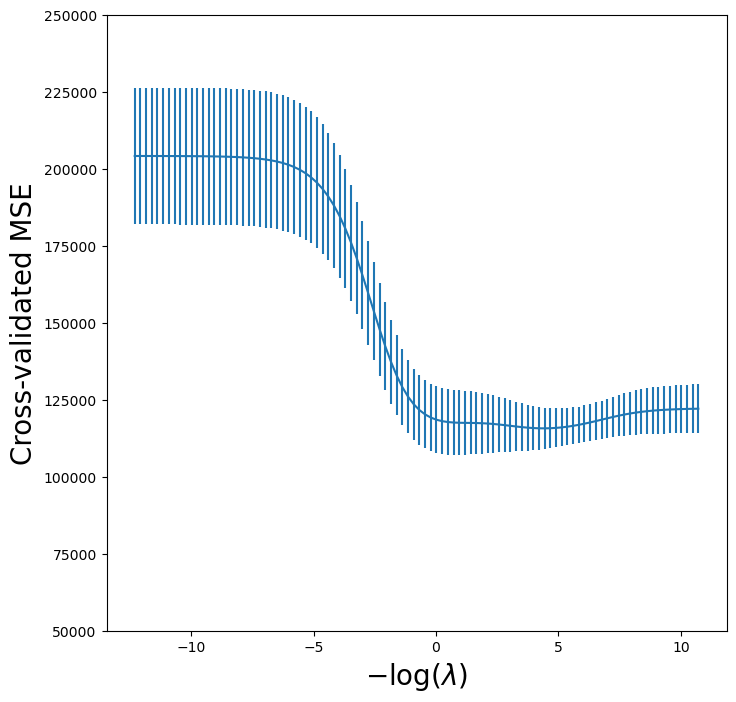

In [32]:
#We now plot the cross-validated MSE as a function of -log(λ), which has shrinkage decresing from left to right
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
           -grid.cv_results_["mean_test_score"],
           yerr=grid.cv_results_["std_test_score"] / np.sqrt(K))
ax.set_ylim([50000,250000])
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-validated MSE", fontsize=20)

In [33]:
#One can cross-validate different metrics to choose a parameter. The default metric for skl.ElasticNet() is test Rsquared.
#Lets compare Rsquared to MSE for cross-validation here
grid_r2= skm.GridSearchCV(pipe, param_grid, cv=kfold)
grid_r2.fit(X, Y)

C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

Text(0, 0.5, 'Cross-validated $R^2$')

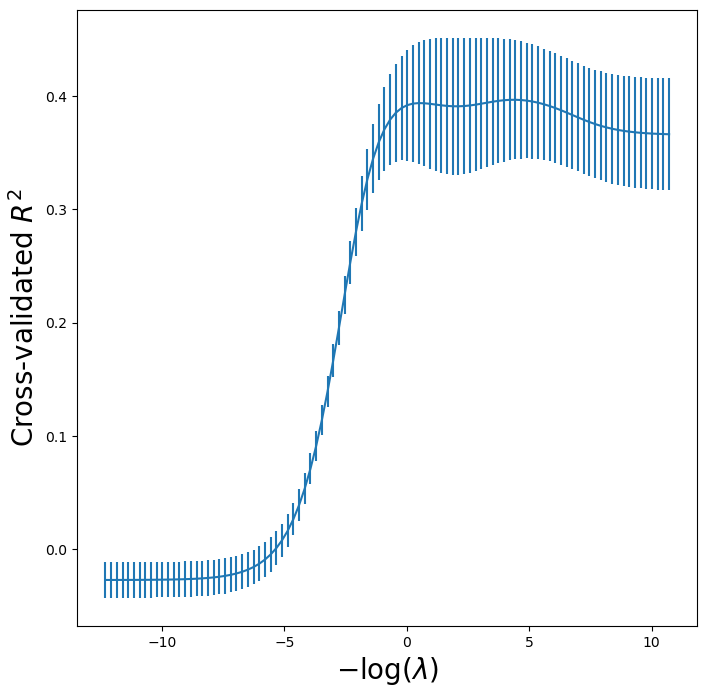

In [34]:
#Lets plot the results for cross-validated Rsquared
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
           grid_r2.cv_results_["mean_test_score"],
           yerr= grid_r2.cv_results_["std_test_score"] / np.sqrt(K))
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-validated $R^2$", fontsize=20)


#### Fast Cross-Validation for Solution Paths

##### The ridge, lasso, and elastic net can be efficiently fit along a sequence of ***λ*** values, creating what is known as a ***solution path*** or ***regularization path***.
##### Hence there is specialized code to fit such paths, and so to choose a suitable value of λ using cross-validation. Even with identical splits the results will not agree exactly with our grid above because the standardization of each feature in grid is carried out on each fold, while in ***pipeCV*** below it is carried out only once.

In [35]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
pipeCV= Pipeline(steps=[("scaler", scaler), ("ridge", ridgeCV)])
pipeCV.fit(X, Y)

C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18795326.355502333, tolerance: 3759.109166869193
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: O

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Text(0, 0.5, 'Cross-Validated MSE')

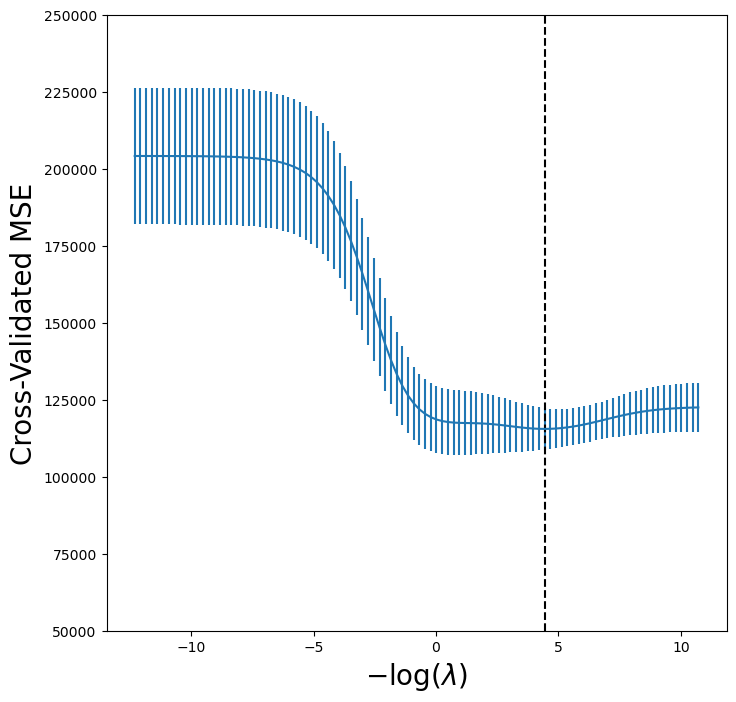

In [36]:
#Lets produce a plot again of the cross-validation error to see that it is similar to using skm.GridSearchCV
tuned_ridge = pipeCV.named_steps["ridge"]
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
           tuned_ridge.mse_path_.mean(1),
           yerr= tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c="k", ls="--")
ax.set_ylim([50000,250000])
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-Validated MSE", fontsize=20)

In [37]:
#we see that the value of lambda that results in the smallest cross-validation error is 1.19e-02, available as tuned_ridge.alpha_.
#What is the test MSE associated with this value of lambda
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987684

In [38]:
#tuned_ridge.coef_ has the coefficients fit on the entire data set at this value of lambda
tuned_ridge.coef_

#As expected, none of the coefficients are zero; ridge regression does not perform variable selection

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

In [39]:
tuned_ridge.alpha_

0.01185247763144249

#### Evaluating Test Error of Cross-Validated Ridge

##### Choosing ***λ*** using cross-validation provides a single regression estimator, similar to fitting a linear regression model.
##### It is therefore reasonable to estimate what its test error is. We run into a problem here in that cross-validation will have touched all of its data in choosing λ , hence we have no further data to estimate test error.
##### Do an initial split of the data into two disjoint sets: ***training set and test set***. We then fit a cross-validation tuned ridge regression on the training set and evaluate its performance on the test set. 
##### We might call this cross-validation nested within the validation set approach.

In [40]:
outer_valid= skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)
inner_cv= skm.KFold(n_splits=5,
                   shuffle=True,
                   random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                          l1_ratio=0,
                          cv=inner_cv)
pipeCV = Pipeline(steps=[("scaler", scaler), ("ridge", ridgeCV)])
results = skm.cross_validate(pipeCV,
                            X,
                            Y,
                            cv=outer_valid,
                            scoring="neg_mean_squared_error")
-results["test_score"]

C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002961.89304734, tolerance: 3200.6325551004934
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: O

array([132393.84003227])

#### The Lasso

##### We saw that ridge regression with a wise choice of λ can outperform least squares as well as the null model on the ***Hitters*** data set.
##### We now ask whether the lasso can yield either a more accurate or a more interpretable modle than ridge regression.
##### In order to fit a lasso model, we once again use the ElasticNetCV() with argument l1_ratio=1.

In [41]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                          l1_ratio=1,
                          cv=kfold)
pipeCV = Pipeline(steps=[("scaler", scaler), ("lasso", lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps["lasso"]
tuned_lasso.alpha_

3.1472370031649883

In [42]:
lambdas, soln_array= skl.Lasso.path(Xs, Y, l1_ratio=1, n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                        columns= D.columns,
                        index= -np.log(lambdas))

Text(0, 0.5, 'Standardized coefficients')

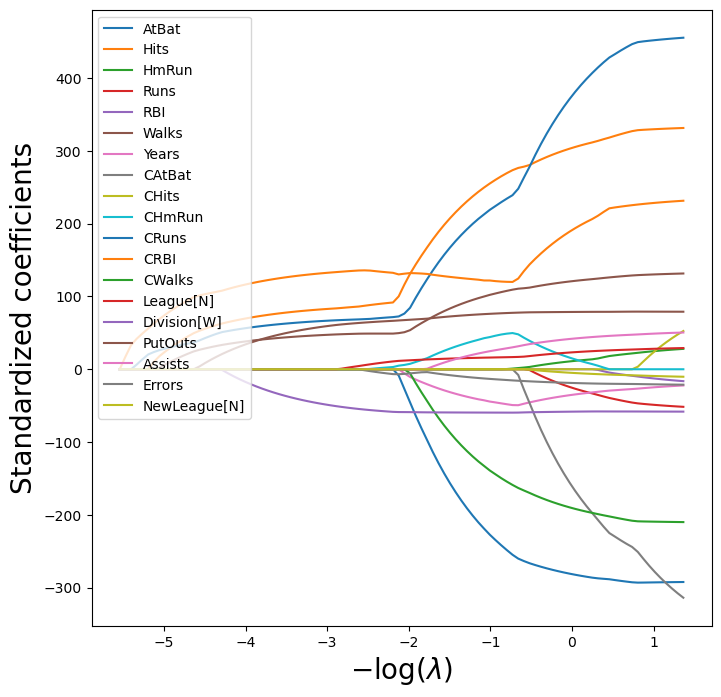

In [43]:
#We can see from the coefficient plot of the standardized coefficients that depending on the choice of tuning parameter, some of the coefficients will be exactly equal to zero
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc="upper left")
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Standardized coefficients", fontsize=20)

In [44]:
# The samllest cross-validated error is lower than the test set MSE of the null model and of least squares, and very similar to the test MSE of 115526.71 of ridge regression
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253653

Text(0, 0.5, 'Cross-validated MSE')

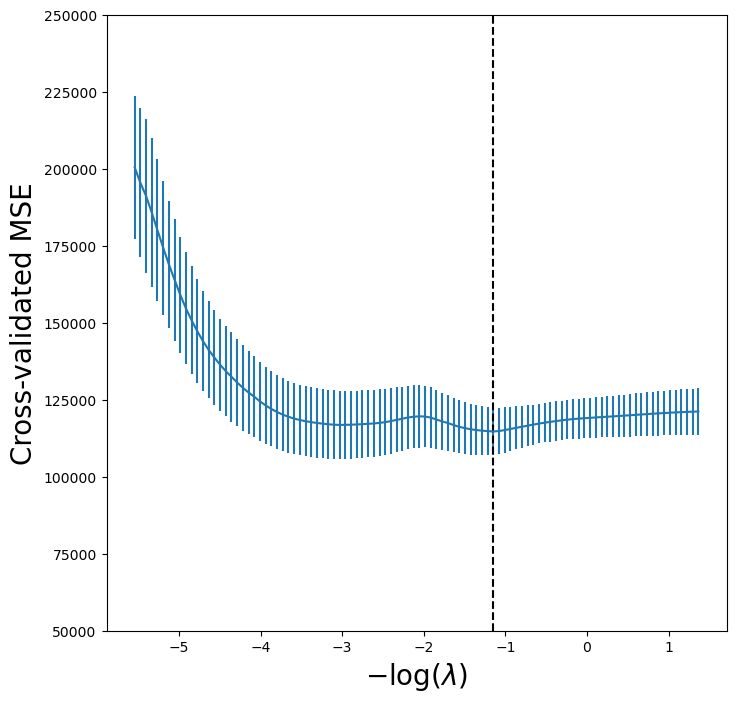

In [45]:
#Lets produce a plot of the cross-validation error
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
           tuned_lasso.mse_path_.mean(1),
           yerr= tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c="k", ls="--")
ax.set_ylim([50000,250000])
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-validated MSE", fontsize=20)

##### The ***lasso*** has a substantial advantage over ***ridge*** regression in that the resulting coefficient estimates are ***sparse***. Here we see that 6 of the 19 coefficient estimates are exactly zero. So the lasso model with lambda chosen by cross-validation contains only 13 variables.

In [46]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

###                     PCR and PLS Regression
#### Principal Component Regression

##### Principal components regression (PCR) can be performed using PCA() from sklearn.decomposition module. We now apply PCR to the Hitters data, in order to predict Salary.
##### We use LinearRegression() to fit the regression model here. it fits an intercept by default unlike the OLS seen earlier.

In [47]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe= Pipeline([("pca", pca), ("linreg", linreg)])
pipe.fit(X, Y)
pipe.named_steps["linreg"].coef_

array([0.09846131, 0.4758765 ])

In [48]:
#when performing PCA, the results vary depending on whether the data has been standardized or not. Lets include additional step
pipe= Pipeline([("scaler", scaler),
               ("pca", pca),
               ("linreg", linreg)])
pipe.fit(X, Y)
pipe.named_steps["linreg"].coef_

array([106.36859204, -21.60350456])

In [49]:
#We can use CV to choose the number of components by using skm-GridSearchCV, in this case fixing the parameters to vary the n_components
param_grid = {"pca__n_components": range(1, 20)}
grid= skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring="neg_mean_squared_error")
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

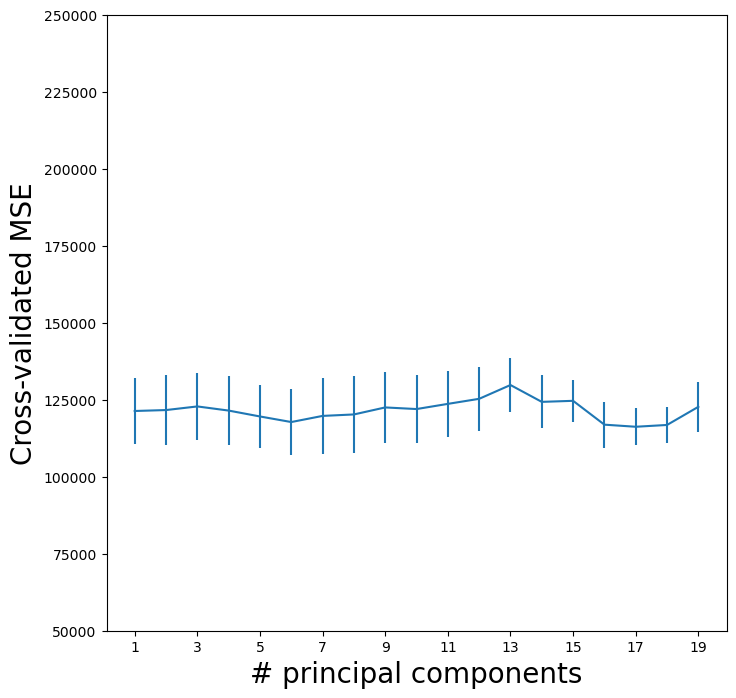

In [50]:
#Lets plot the results
pcr_fig, ax = subplots(figsize=(8,8))
n_comp= param_grid["pca__n_components"]
ax.errorbar(n_comp,
           -grid.cv_results_["mean_test_score"],
           grid.cv_results_["std_test_score"] / np.sqrt(K))
ax.set_ylabel("Cross-validated MSE", fontsize=20)
ax.set_xlabel("# principal components", fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000, 250000])

#We see that the smallest cross-validation error occurs when 17 components are used. However, from the plot we also see that the CV error is roughly the same when only one component is included in the model.
#This suggests that a model that uses just a small number of components might suffice.

In [51]:
# The CV score provided for each possible number of components from 1-19 inclusive. The PCA() method complains if we try to fit an intercept only with n_components=0, so we also compute the MSE for jst the null model with these splits
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg, Xn, Y, cv=kfold, scoring="neg_mean_squared_error")
-cv_null["test_score"].mean()
              
              

204139.30692994667

In [52]:
#The explained_variance_ratio attribute of our PCA object provides the percentage of variance explained in the predictors and in the response using different number of components
pipe.named_steps["pca"].explained_variance_ratio_

#Briefly, we can think of this as the amount of information about the predictors that is captured using M principal components. For example, setting M=1only captures 38.31% of the variance, while M =2captures an additional 21.84%, for a total of 60.15% of the variance. By M =6it increases to 88.63%. Beyond this the increments continue to diminish, until we use all M =p=19 components, which captures all 100% of the variance.

array([0.3831424 , 0.21841076])

#### Partial Least Squares


In [54]:
pls= PLSRegression(n_components=2, scale=True)
pls.fit(X, Y)

#As was the PCR, we will want to use CV to choose the number of components
param_grid = {"n_components": range(1,20)}
grid= skm.GridSearchCV(pls, param_grid, cv=kfold, scoring="neg_mean_squared_error")
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

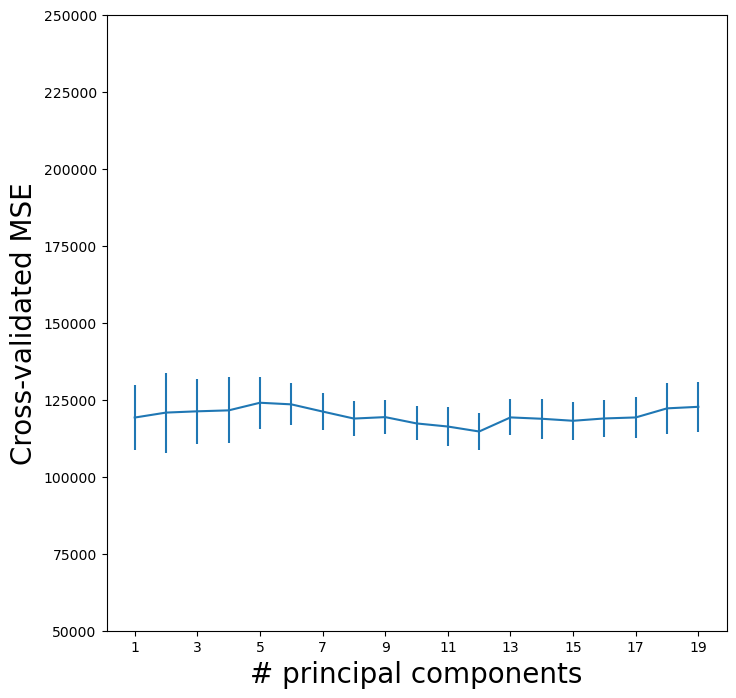

In [55]:
#Lets plot the MSE
pls_fig, ax= subplots(figsize=(8,8))
n_comp = param_grid["n_components"]
ax.errorbar(n_comp,
           -grid.cv_results_["mean_test_score"],
           grid.cv_results_["std_test_score"] / np.sqrt(K))
ax.set_ylabel("Cross-validated MSE", fontsize=20)
ax.set_xlabel("# principal components", fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000])

#CV error is minimized at 12, though there is little noticeable difference between this point and much lower number like 2 or 3 components

#### Question 
##### In this exercise, we will predict the number of applications received using the other variables in the ***College*** data set.
##### ***(a)*** Split the data set into a training and a test set.

In [60]:
from sklearn.model_selection import train_test_split
College = load_data("College")
#response variable
y = np.array(College["Apps"])
design=MS(College.drop(columns=["Apps"])).fit(College)
X= design.transform(College)
#split the data into training(80%) and test(20%) sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)

##### ***(b)*** Fit a linear model using least squares on the training set, and report the test error obtained

In [61]:
from sklearn.metrics import mean_squared_error
#fit linear model on training set
ols_model= OLS(y_train, X_train).fit()
#predict on the test set
y_pred= ols_model.predict(X_test)
#compute test MSE
test_mse = mean_squared_error(y_test, y_pred)
test_rmse= np.sqrt(test_mse) #root mean squared error
test_mse, test_rmse

(1176083.9778029558, 1084.474055845946)

##### ***(c)*** Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained

In [81]:
lambdas = 10**np.linspace(8, -2, 100) / y.std()
kfold= skm.KFold(n_splits=5,shuffle=True, random_state=0)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
ridgeCV.fit(X_train, y_train)
#best alpha
ridgeCV.alpha_
#predict on the test set
y_pred_ridge= ridgeCV.predict(X_test)
#Test error
ridgeMSE= mean_squared_error(y_test, y_pred_ridge) #or  ((y_test - y_pred_ridge)**2).mean()
ridgeMSE

#        Alternative
#ridgeCV= skl.RidgeCV(alphas=lambdas, store_cv_values=True)
#ridgeCV.fit(X_train, y_train)
#ridgeCV.alpha_
#predict on test set
#y_pred_ridge= ridgeCV.predict(X_test)
#test error
#ridge_mse = mean_squared_error(y_test, y_pred_ridge)
#ridge_mse

C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297204397.3763512, tolerance: 687622.2180046372
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\colli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Ob

1173432.2675395464

##### ***(d)*** Fit a lasso model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficients


In [84]:
lassoCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=kfold)
lassoCV.fit(X_train, y_train)
lassoCV.alpha_
y_pred_lasso = lassoCV.predict(X_test)
#test error
lassoMSE = mean_squared_error(y_test, y_pred_lasso)
lassoMSE, lassoCV.coef_

(1167865.9324873793,
 array([ 0.00000000e+00, -0.00000000e+00,  1.62985055e+00, -1.03986510e+00,
         5.11603347e+01, -1.36484802e+01,  8.74080612e-02,  5.96847712e-02,
        -1.05586390e-01,  1.51708503e-01,  4.59324691e-03, -1.51085333e-02,
        -7.08830101e+00, -1.07696736e+00,  0.00000000e+00, -0.00000000e+00,
         5.35508009e-02,  6.25954540e+00]))

##### ***(e)*** Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

In [93]:

n_features= X_train.shape[1]
pca = PCA(n_components=n_features)
linreg = skl.LinearRegression()
pipe= Pipeline([("pca", pca), ("linreg", linreg)])
pipe.fit(X_train, y_train)
pipe.named_steps["linreg"].coef_

#range of possible M values(1 to all features)
param_grid={"pca__n_components": list(range(1, n_features+1))}
#grid search with 5-fold CV
grid= skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring="neg_mean_squared_error")
#fit on training data
grid.fit(X_train, y_train)
#best M
best_M= grid.best_params_["pca__n_components"]
best_M

# predict on test set using best model
y_pred_pcr = grid.best_estimator_.predict(X_test)
#Test error
pcr_mse = mean_squared_error(y_test, y_pred_pcr)
pcr_mse

1182053.1617344813

##### ***(f)*** Fit a PLS model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

In [97]:
pls= PLSRegression(n_components=n_features, scale=True)
pls.fit(X_train, y_train)
#grid search with 5 fold CV
param_grid={"n_components": list(range(1, n_features+1))}
pls_grid= skm.GridSearchCV(pls, param_grid, cv=kfold, scoring="neg_mean_squared_error")

#fit on training set
pls_grid.fit(X_train, y_train)
best_M_pls= pls_grid.best_params_["n_components"]
best_M_pls

#predict on test set
y_pred_pls= pls_grid.best_estimator_.predict(X_test)

#Test error
pls_mse = mean_squared_error(y_test, y_pred_pls)
pls_mse


1176083.9778028545

##### ***(g)*** Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

##### All models have a test MSE approx. 1.17 million
##### Since the response variable(Apps) is in units of number of applications, an RMSE around 1,080 applications(sqrt(MSE)) means predictions are typically off by about 1,000 applications.
##### Lasso gives the lowest MSE suggesting that variable selection slightly improves prediction.
##### There is little practical difference among OLS, Ridge, Lasso, PCR, and PLS on this dataset.
